# Used Car Prices
In this project we will explore how to use CatBoost, an algorithm for gradient boosting on decision trees. The dataset contains historical car auction sales prices and was scraped from outside internet sources. The dataset has been collected in 2015. The dataset can be found in following link: https://www.kaggle.com/tunguz/used-car-auction-prices 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pytz
import re
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from catboost import CatBoostRegressor
import ipywidgets as widgets
from sklearn.model_selection import train_test_split


# Data Wrangling/Exploration
## Cleaning
This data is far from clean and while trying to read the csv file we find that the format of the file contains extra commas that cannot be detected by pandas read_csv function. So this may be an issue with how the data was scraped so we use the on_bad_lines parameter to print which lines are faulty so we can see what is going on.

In [2]:
df = pd.read_csv('car_prices.csv', header=0, on_bad_lines='warn')
df.head()

b'Skipping line 408163: expected 16 fields, saw 17\nSkipping line 417837: expected 16 fields, saw 17\nSkipping line 421291: expected 16 fields, saw 17\nSkipping line 424163: expected 16 fields, saw 17\n'
b'Skipping line 427042: expected 16 fields, saw 17\nSkipping line 427045: expected 16 fields, saw 17\nSkipping line 434426: expected 16 fields, saw 17\nSkipping line 444503: expected 16 fields, saw 17\nSkipping line 453796: expected 16 fields, saw 17\n'
b'Skipping line 461599: expected 16 fields, saw 17\nSkipping line 461614: expected 16 fields, saw 17\n'
b'Skipping line 492486: expected 16 fields, saw 17\nSkipping line 497010: expected 16 fields, saw 17\nSkipping line 497013: expected 16 fields, saw 17\nSkipping line 499085: expected 16 fields, saw 17\nSkipping line 501457: expected 16 fields, saw 17\nSkipping line 505301: expected 16 fields, saw 17\nSkipping line 505308: expected 16 fields, saw 17\nSkipping line 520463: expected 16 fields, saw 17\n'
b'Skipping line 528998: expected 1

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,"kia motors america, inc",20500,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,"kia motors america, inc",20800,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,4.5,1331.0,gray,black,financial services remarketing (lease),31900,30000,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,4.1,14282.0,white,black,volvo na rep/world omni,27500,27750,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,4.3,2641.0,gray,black,financial services remarketing (lease),66000,67000,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)




By copying and pasting the error message and using a little regex, we can extract the lines that were skipped.



In [3]:
error = "b'Skipping line 408163: expected 16 fields, saw 17\nSkipping line 417837: expected 16 fields, saw 17\nSkipping line 421291: expected 16 fields, saw 17\nSkipping line 424163: expected 16 fields, saw 17\n'\
b'Skipping line 427042: expected 16 fields, saw 17\nSkipping line 427045: expected 16 fields, saw 17\nSkipping line 434426: expected 16 fields, saw 17\nSkipping line 444503: expected 16 fields, saw 17\nSkipping line 453796: expected 16 fields, saw 17\n'\
b'Skipping line 461599: expected 16 fields, saw 17\nSkipping line 461614: expected 16 fields, saw 17\n'\
b'Skipping line 492486: expected 16 fields, saw 17\nSkipping line 497010: expected 16 fields, saw 17\nSkipping line 497013: expected 16 fields, saw 17\nSkipping line 499085: expected 16 fields, saw 17\nSkipping line 501457: expected 16 fields, saw 17\nSkipping line 505301: expected 16 fields, saw 17\nSkipping line 505308: expected 16 fields, saw 17\nSkipping line 520463: expected 16 fields, saw 17\n'\
b'Skipping line 528998: expected 16 fields, saw 17\nSkipping line 529011: expected 16 fields, saw 17\nSkipping line 529015: expected 16 fields, saw 17\nSkipping line 529624: expected 16 fields, saw 17\nSkipping line 548786: expected 16 fields, saw 17\nSkipping line 551224: expected 16 fields, saw 17\nSkipping line 554712: expected 16 fields, saw 17\n'"


regex = r"(\s[0-9]+:)"
skippedLines = re.findall(regex, error)
skippedLines = [int(line[1:-1]) for line in skippedLines]
print(skippedLines)

[408163, 417837, 421291, 424163, 427042, 427045, 434426, 444503, 453796, 461599, 461614, 492486, 497010, 497013, 499085, 501457, 505301, 505308, 520463, 528998, 529011, 529015, 529624, 548786, 551224, 554712]


Now we will explore if there was a specific pattern for why these lines were skipped and find that there was a formatting error for the trim data. The correct format of the string should have been enclosed in quotes like as follows:
'SE PZEV Connectivity,  Navitgation'

So for future pipelines we can change how the data is scraped or read the data in manually line by line and have a specific case for these instances.


In [4]:
a_file = open('car_prices.csv')
df2 = []
for position, line in enumerate(a_file):
    #have to add 1 cause of the header line
    if position+1 in skippedLines:
        temp = line.replace('w/','').split(',')
        print(temp)
        if temp[4] == ' Navitgation':
            temp[3] = temp[3] + temp[4]
            del temp[4]
        df2.append(temp)  
a_file.close()

['2015', 'Volkswagen', 'Jetta', 'SE PZEV Connectivity', ' Navitgation', 'Sedan', 'automatic', '3vwd17aj4fm201708', 'oh', '4.6', '4802', 'silver', 'gray', '"vw credit prequalified"', '13200', '16500', 'Tue Jun 16 2015 02:30:00 GMT-0700 (PDT)\n']
['2015', 'Volkswagen', 'Jetta', 'SE PZEV Connectivity', ' Navitgation', 'Sedan', 'automatic', '3vwd17aj2fm258506', 'ms', '1', '9410', 'white', 'gray', '"enterprise vehicle exchange / tra / birmingham"', '13300', '10500', 'Thu May 07 2015 05:01:00 GMT-0700 (PDT)\n']
['2015', 'Volkswagen', 'Jetta', 'SE PZEV Connectivity', ' Navitgation', 'Sedan', 'automatic', '3vwd17aj3fm276741', 'co', '4.6', '1167', 'blue', 'black', '"tdaf remarketing"', '13200', '12700', 'Tue Jun 16 2015 05:00:00 GMT-0700 (PDT)\n']
['2015', 'Volkswagen', 'Jetta', 'SE PZEV Connectivity', ' Navitgation', 'Sedan', 'automatic', '3vwd17aj2fm285365', 'ms', '1', '2172', 'gray', 'black', '"enterprise vehicle exchange / tra / birmingham"', '14050', '8250', 'Thu May 14 2015 05:01:00 GMT-0

In [5]:
df2=pd.DataFrame(data=df2,columns=df.columns)
df.append(df2)
df.reset_index
df.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,"kia motors america, inc",20500,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,"kia motors america, inc",20800,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,4.5,1331.0,gray,black,financial services remarketing (lease),31900,30000,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,4.1,14282.0,white,black,volvo na rep/world omni,27500,27750,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,4.3,2641.0,gray,black,financial services remarketing (lease),66000,67000,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


In [6]:
dfnulls = df[df.isna().any(axis=1)]
dfnulls.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
14,2014,Chevrolet,Cruze,2LT,Sedan,automatic,1g1pe5sbxe7120097,ca,NaN,15686.0,blue,black,avis rac/san leandro,13900,10600,Tue Dec 16 2014 12:00:00 GMT-0800 (PST)
16,2015,Hyundai,Sonata,SE,Sedan,NaN,5npe24af4fh001562,ca,NaN,8311.0,red,—,avis tra,15200,4200,Tue Dec 16 2014 13:00:00 GMT-0800 (PST)
22,2014,Chevrolet,Camaro,LT,Convertible,automatic,2g1fb3d31e9134662,ca,NaN,33450.0,black,black,avis rac/san leandro,20100,14700,Tue Dec 16 2014 12:00:00 GMT-0800 (PST)
25,2015,Hyundai,Sonata,SE,Sedan,automatic,5npe24af4fh038482,ca,NaN,9281.0,silver,gray,enterprise vehicle exchange / tra / rental / t...,15150,8500,Tue Dec 16 2014 13:00:00 GMT-0800 (PST)
28,2014,BMW,X5,sDrive35i,SUV,automatic,5uxkr2c52e0h33130,ca,NaN,11278.0,gray,black,avis rac/san leandro,50400,34000,Tue Dec 16 2014 13:00:00 GMT-0800 (PST)


## Data Imputation
If we dropped the rows with missing values we would lose about 15% of our data set and there are high correlations for the year in which the car was made and the odometer, so we can use some data imputations to help fill in the missing data. Also there is a really high correlation for the mmr and the selling price. The Manheim Market Report (MMR) tool offers pricing and market information so sellers can price vehicles competitively and buyers can bid with confidence. This is probably why there is such a high correlation so maybe we don't even have to create our own algorithm. But later on we will explore what would happen if we didn't have the mmr to see understand the data better.

In [7]:
(len(df.index) - len(df.dropna().index)) / len(df.index) 

0.15474820645978693

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558811 entries, 0 to 558810
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          558811 non-null  int64  
 1   make          548510 non-null  object 
 2   model         548412 non-null  object 
 3   trim          548160 non-null  object 
 4   body          545616 non-null  object 
 5   transmission  493458 non-null  object 
 6   vin           558811 non-null  object 
 7   state         558811 non-null  object 
 8   condition     547017 non-null  float64
 9   odometer      558717 non-null  float64
 10  color         558062 non-null  object 
 11  interior      558062 non-null  object 
 12  seller        558811 non-null  object 
 13  mmr           558811 non-null  int64  
 14  sellingprice  558811 non-null  int64  
 15  saledate      558811 non-null  object 
dtypes: float64(2), int64(3), object(11)
memory usage: 68.2+ MB


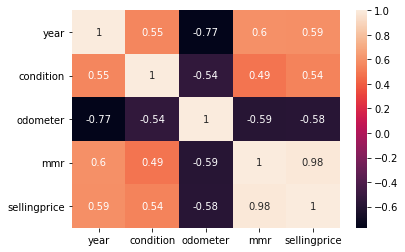

In [9]:
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [10]:
imp = IterativeImputer(max_iter=10, random_state=0)
np_imp = imp.fit_transform(df[['year', 'condition', 'odometer', 'mmr', 'sellingprice']])
df['condition'] = np_imp[:,1]
df['odometer'] = np_imp[:,2]

In [11]:
def disp_categorical(df,non_num):
    # Check distribution (cat)
    print(f'=== Distribution of categorical features  ===')
    plt.figure(figsize=(30, 30))
    for i, col in enumerate(non_num):
        # Plot distribution 
        plt.subplot(4,3,i+1); sns.countplot(x=df[col], color='blue')
        plt.title(f'Distribution of {col}')
        plt.xticks(rotation=90)
    # Show the plot
    plt.tight_layout()
    plt.show()

=== Distribution of categorical features  ===


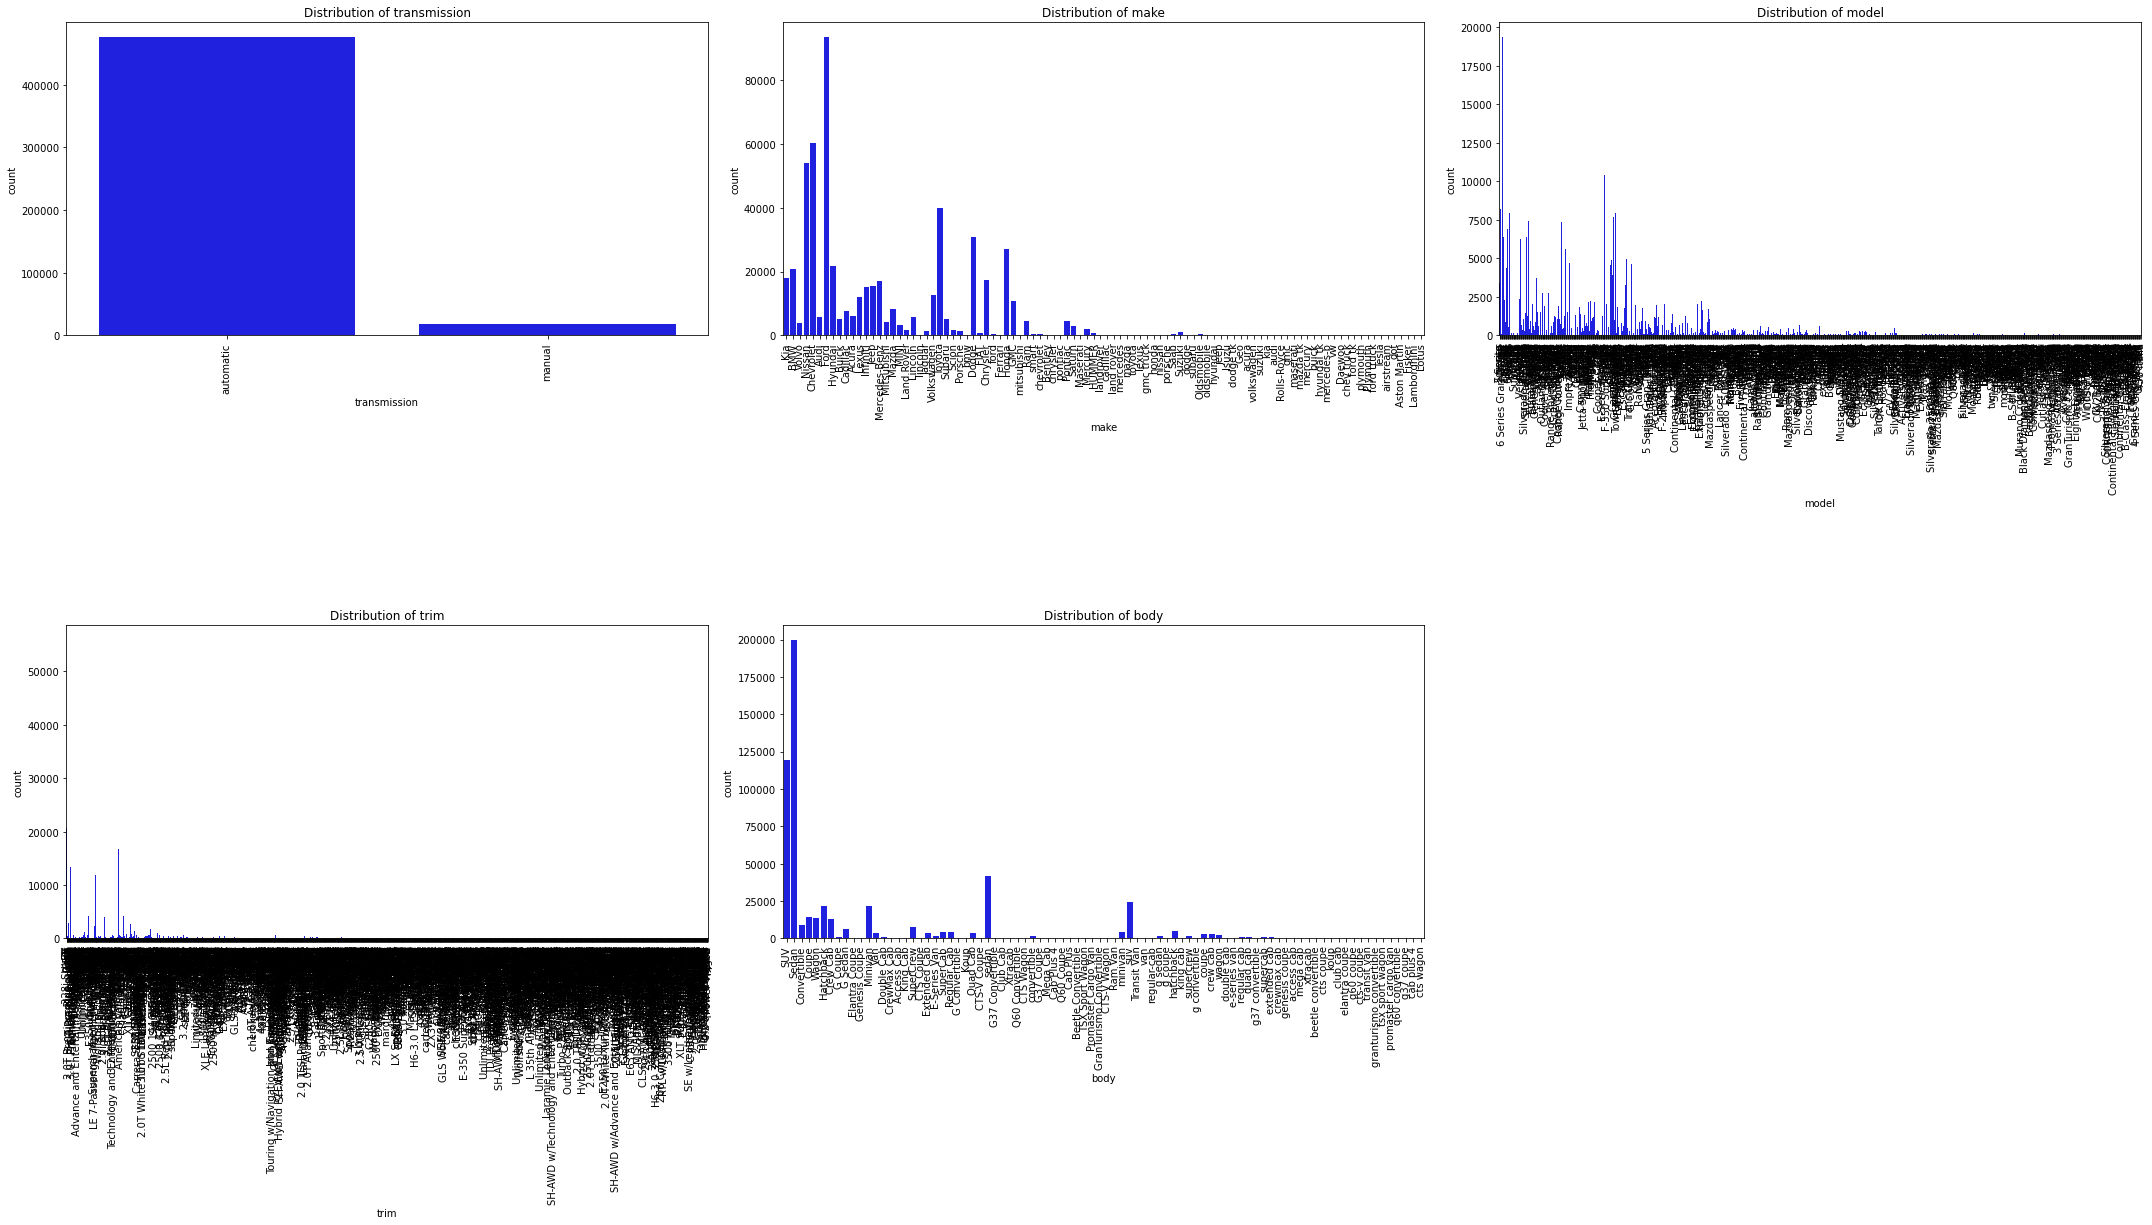

In [12]:
disp_categorical(df,['transmission','make', 'model', 'trim', 'body'])

Because a majority of transmissions are automatic and for the most part modern cars are now automatic we could impute it based on the mode of the data. 

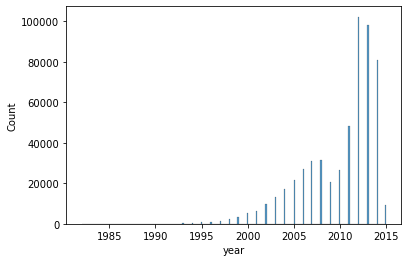

In [13]:
sns.histplot(df['year']);

In [14]:
df['transmission'] = df['transmission'].fillna(df['transmission'].mode().iloc[0])

Now as we can see we have significantly reduced the amount of missing values of our dataset and we can drop the rest of the rows with nan values because it would not be worth the effort to explore the rest of the cases.

In [15]:
(len(df.index) - len(df.dropna().index)) / len(df.index) 

0.02508182551882479

In [16]:
df = df.dropna()

## Feature extracting (Sale Date)
We can gather more insight by extracting certain aspects of the date such as the year, month, week, etc...

In [17]:
df['saledate'] = df['saledate'].apply(lambda s: datetime.strptime(s[:-6], '%a %b %d %Y %X %Z%z').astimezone(pytz.utc))

In [18]:
df['saledate_year'] = df['saledate'].dt.year
df['saledate_month'] = df['saledate'].dt.month
df['saledate_week'] = df['saledate'].dt.isocalendar().week
df['saledate_day'] = df['saledate'].dt.day
df['saledate_hour'] = df['saledate'].dt.hour
df['saledate_minute'] = df['saledate'].dt.minute
df['saledate_dayofweek'] = df['saledate'].dt.dayofweek

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 544795 entries, 0 to 558810
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   year                544795 non-null  int64              
 1   make                544795 non-null  object             
 2   model               544795 non-null  object             
 3   trim                544795 non-null  object             
 4   body                544795 non-null  object             
 5   transmission        544795 non-null  object             
 6   vin                 544795 non-null  object             
 7   state               544795 non-null  object             
 8   condition           544795 non-null  float64            
 9   odometer            544795 non-null  float64            
 10  color               544795 non-null  object             
 11  interior            544795 non-null  object             
 12  seller          

## Data Normalization
Data normalization is not needed for catboost because it is a form of a decision tree which is not affected by monotonic transformations. We can use it for other models. 

In [20]:
df.describe()

,year,condition,odometer,mmr,sellingprice,saledate_year,saledate_month,saledate_week,saledate_day,saledate_hour,saledate_minute,saledate_dayofweek
count,544795.000000,544795.000000,544795.000000,544795.00000,544795.000000,544795.000000,544795.000000,544795.000000,544795.000000,544795.000000,544795.000000,544795.000000
mean,2010.139911,3.421874,67290.673935,13872.82051,13712.814009,2014.904786,3.796881,13.952450,15.403036,11.498705,16.324627,2.147696
std,3.887104,0.944383,52703.083534,9606.43230,9677.142801,0.293510,3.221814,12.927833,8.541501,3.542454,15.272085,1.042715
min,1990.000000,-2.261608,-21754.995255,25.00000,1.000000,2014.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2008.000000,2.700000,28080.500000,7325.00000,7100.000000,2015.000000,1.000000,5.000000,8.000000,9.000000,0.000000,1.000000
50%,2012.000000,3.600000,51174.000000,12350.00000,12200.000000,2015.000000,2.000000,8.000000,16.000000,10.000000,15.000000,2.000000
75%,2013.000000,4.200000,97559.000000,18400.00000,18300.000000,2015.000000,6.000000,23.000000,22.000000,12.000000,30.000000,3.000000
max,2015.000000,6.484681,999999.000000,182000.00000,230000.000000,2015.000000,12.000000,52.000000,31.000000,23.000000,59.000000,6.000000


=== Distribution of features (before log transformation) ===


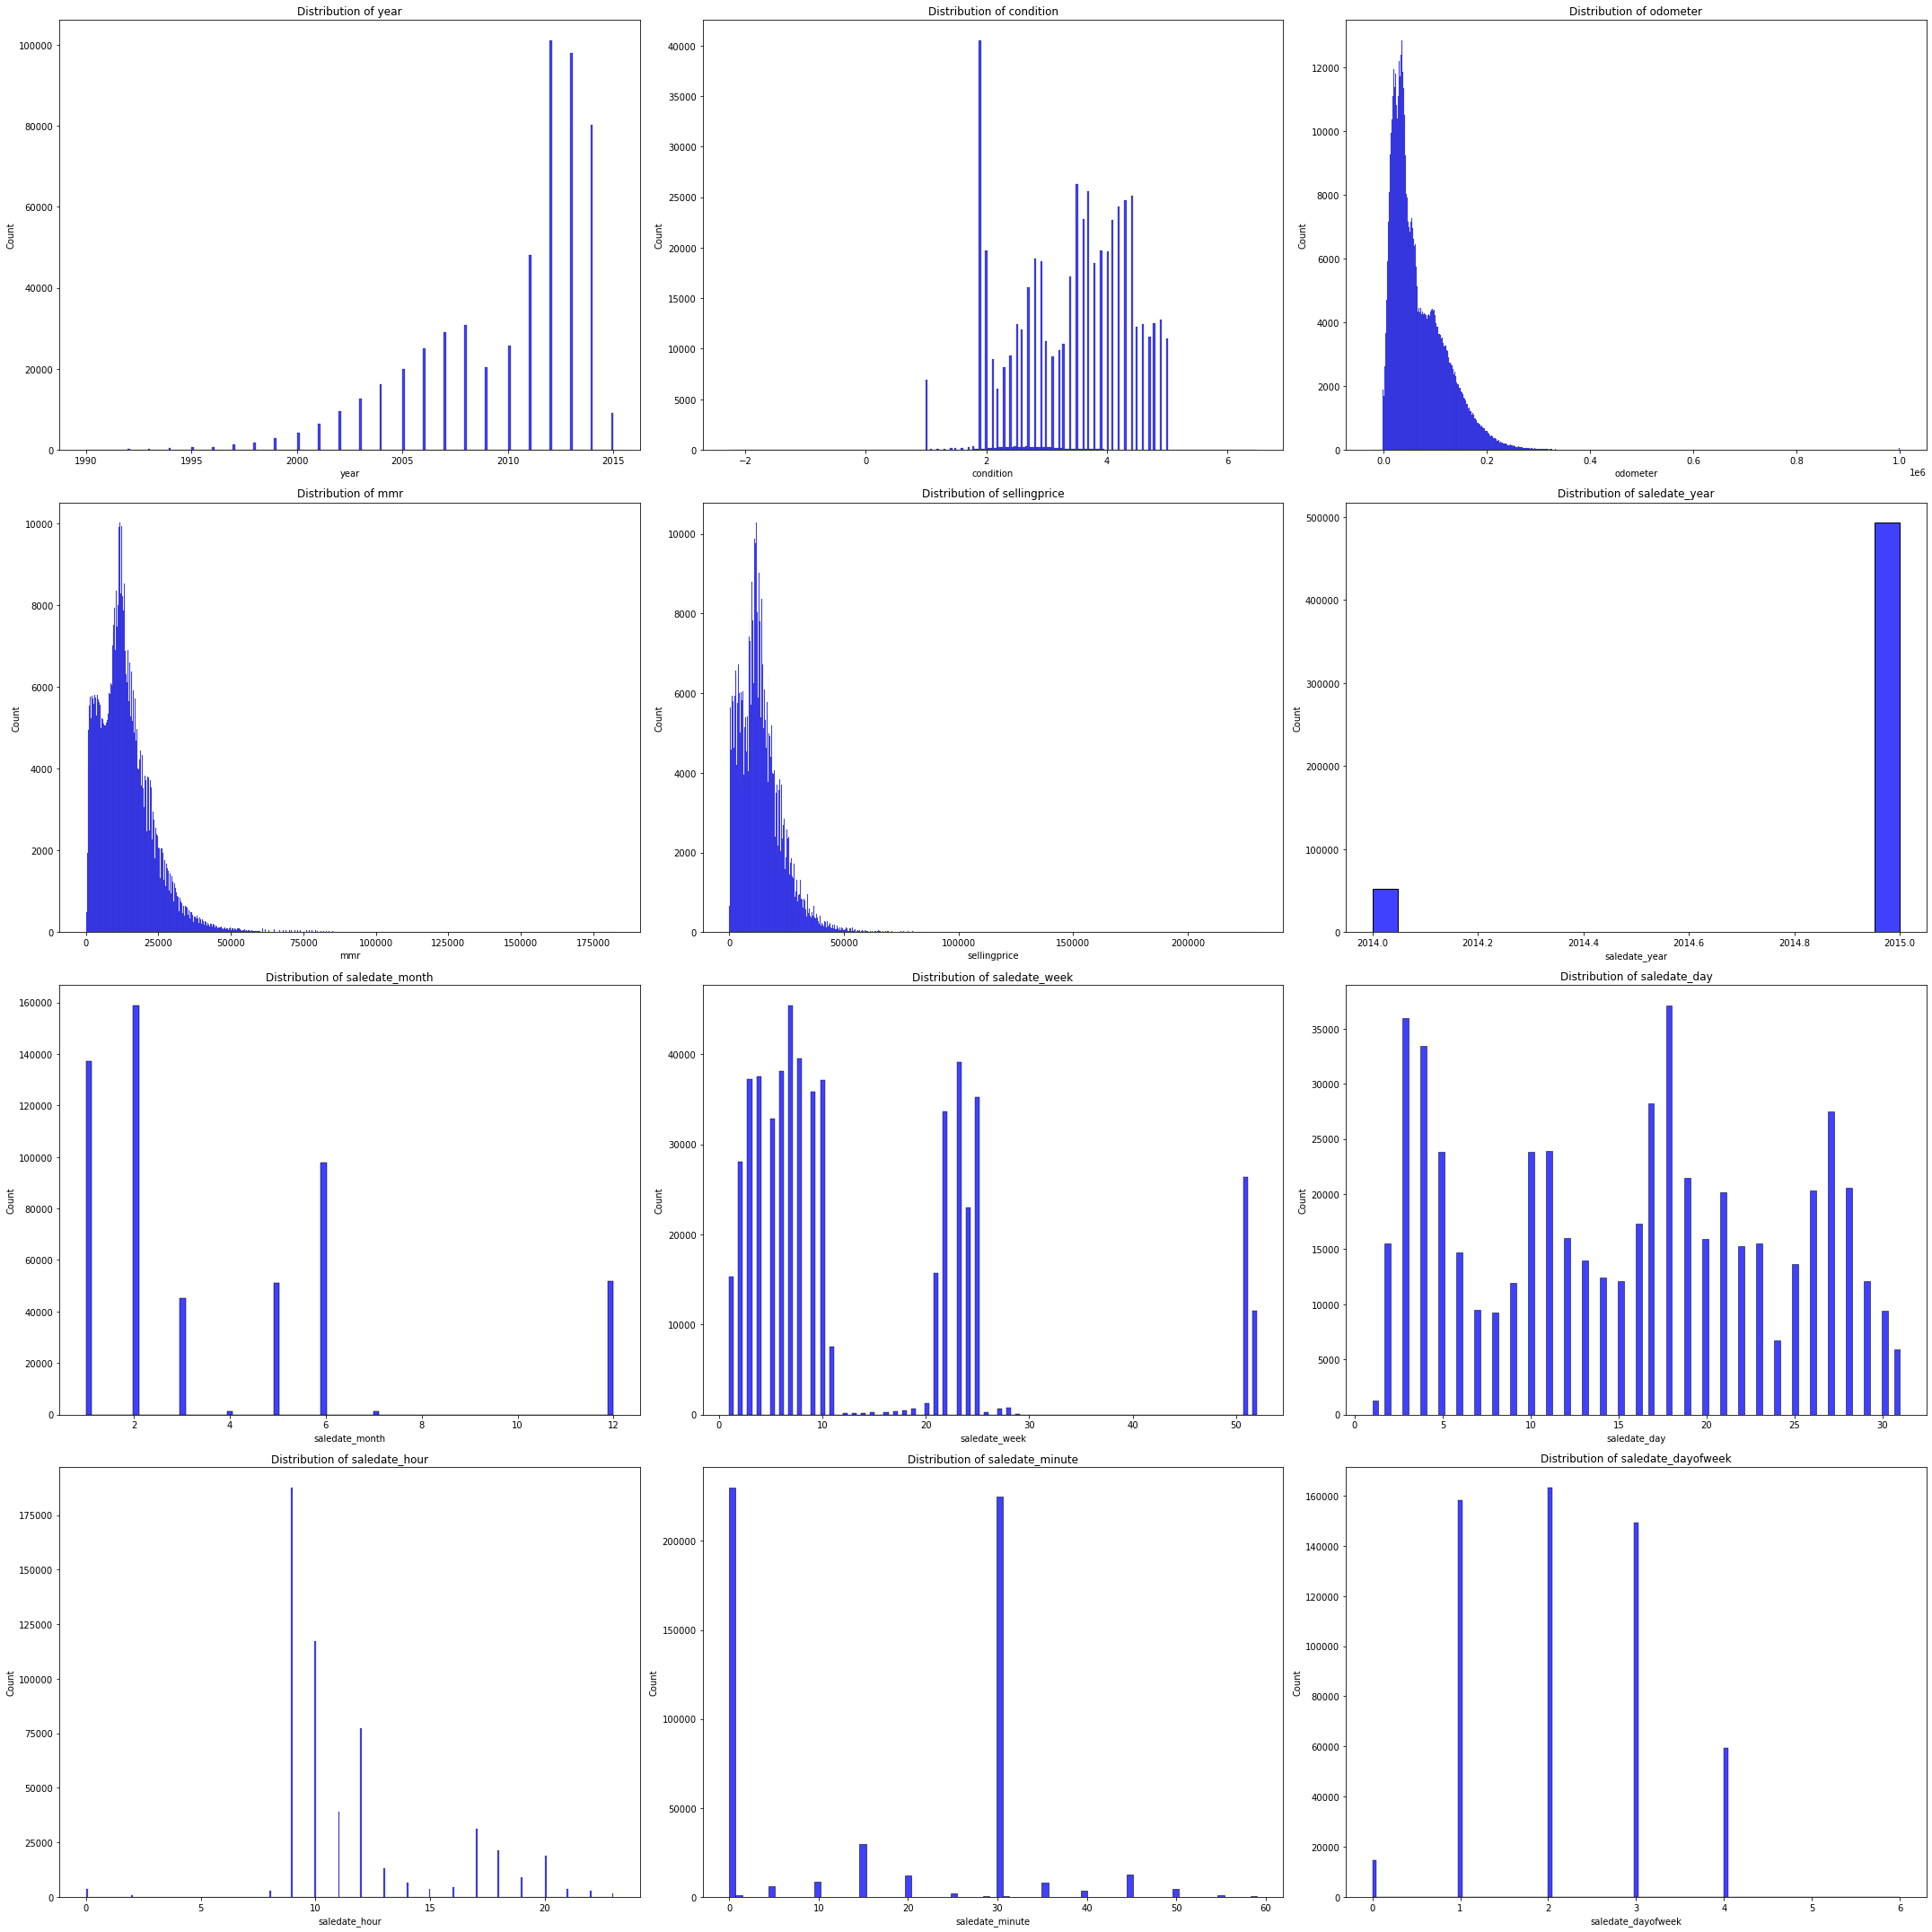

In [21]:
num = ['year', 'condition','odometer','mmr','sellingprice','saledate_year','saledate_month','saledate_week','saledate_day','saledate_hour','saledate_minute','saledate_dayofweek']
print(f'=== Distribution of features (before log transformation) ===')
plt.figure(figsize=(30, 30))
for i, col in enumerate(num):
    # Plot distribution 
    plt.subplot(4,3,i+1); sns.histplot(df[col], color='blue')
    plt.title(f'Distribution of {col}')
# Show the plot
plt.tight_layout()
plt.show()

In [22]:
# Log transform function
def log_transform(data, to_log):
    X = data.copy()
    for item in to_log:
        # Add 1 to the data to prevent infinity values
        X[item] = np.log(1+X[item])
    return X

In [23]:
to_log = ['condition','odometer','mmr','sellingprice']
df_log = log_transform(df, to_log)
df_log.head()

F:\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,year,make,model,trim,body,transmission,vin,state,condition,odometer,...,mmr,sellingprice,saledate,saledate_year,saledate_month,saledate_week,saledate_day,saledate_hour,saledate_minute,saledate_dayofweek
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,1.791759,9.719565,...,9.928229,9.975855,2014-12-16 20:30:00+00:00,2014,12,51,16,20,30,1
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,1.791759,9.147826,...,9.942756,9.975855,2014-12-16 20:30:00+00:00,2014,12,51,16,20,30,1
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,1.704748,7.194437,...,10.370393,10.308986,2015-01-15 12:30:00+00:00,2015,1,3,15,12,30,3
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,1.629241,9.566825,...,10.221978,10.231027,2015-01-29 12:30:00+00:00,2015,1,5,29,12,30,3
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,1.667707,7.879291,...,11.097425,11.112463,2014-12-18 20:30:00+00:00,2014,12,51,18,20,30,3


=== Distribution of features (after log transformation) ===


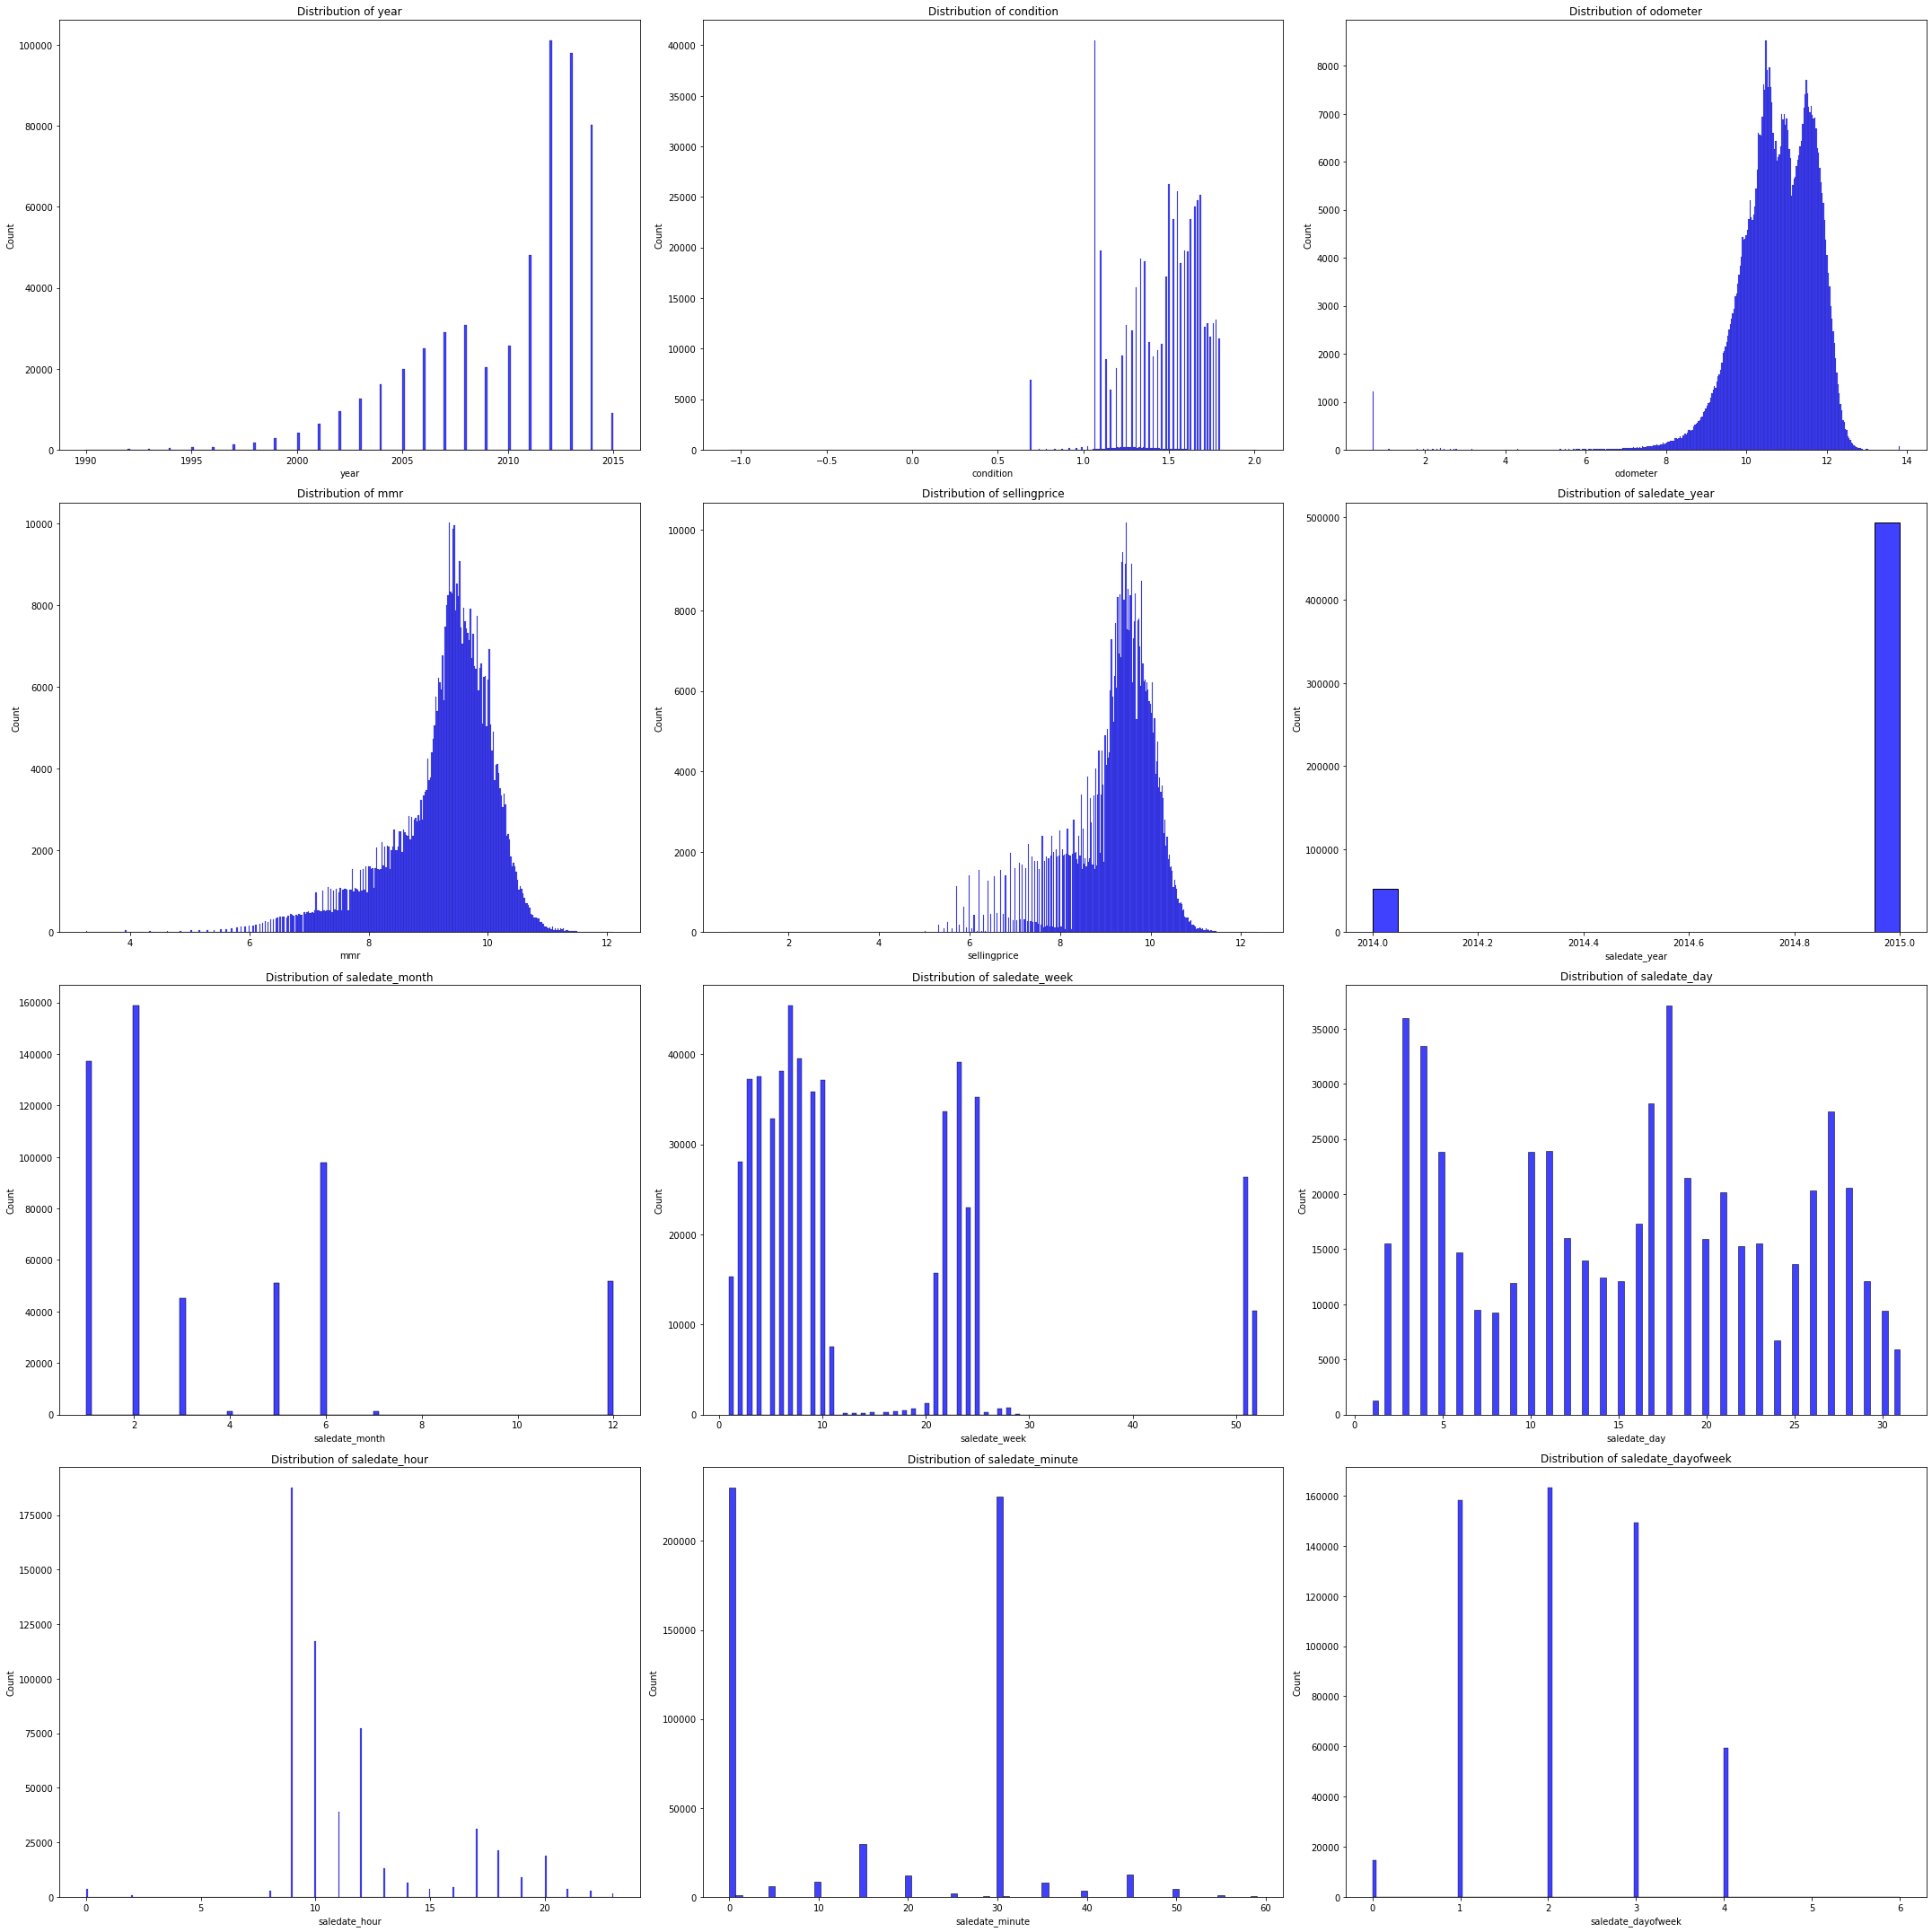

In [24]:
# Check distribution (num)
print(f'=== Distribution of features (after log transformation) ===')
plt.figure(figsize=(30, 30))
for i, col in enumerate(num):
    # Plot distribution 
    plt.subplot(4,3,i+1); sns.histplot(df_log[col], color='blue')
    plt.title(f'Distribution of {col}')
# Show the plot
plt.tight_layout()
plt.show()

=== Distribution of categorical features  ===


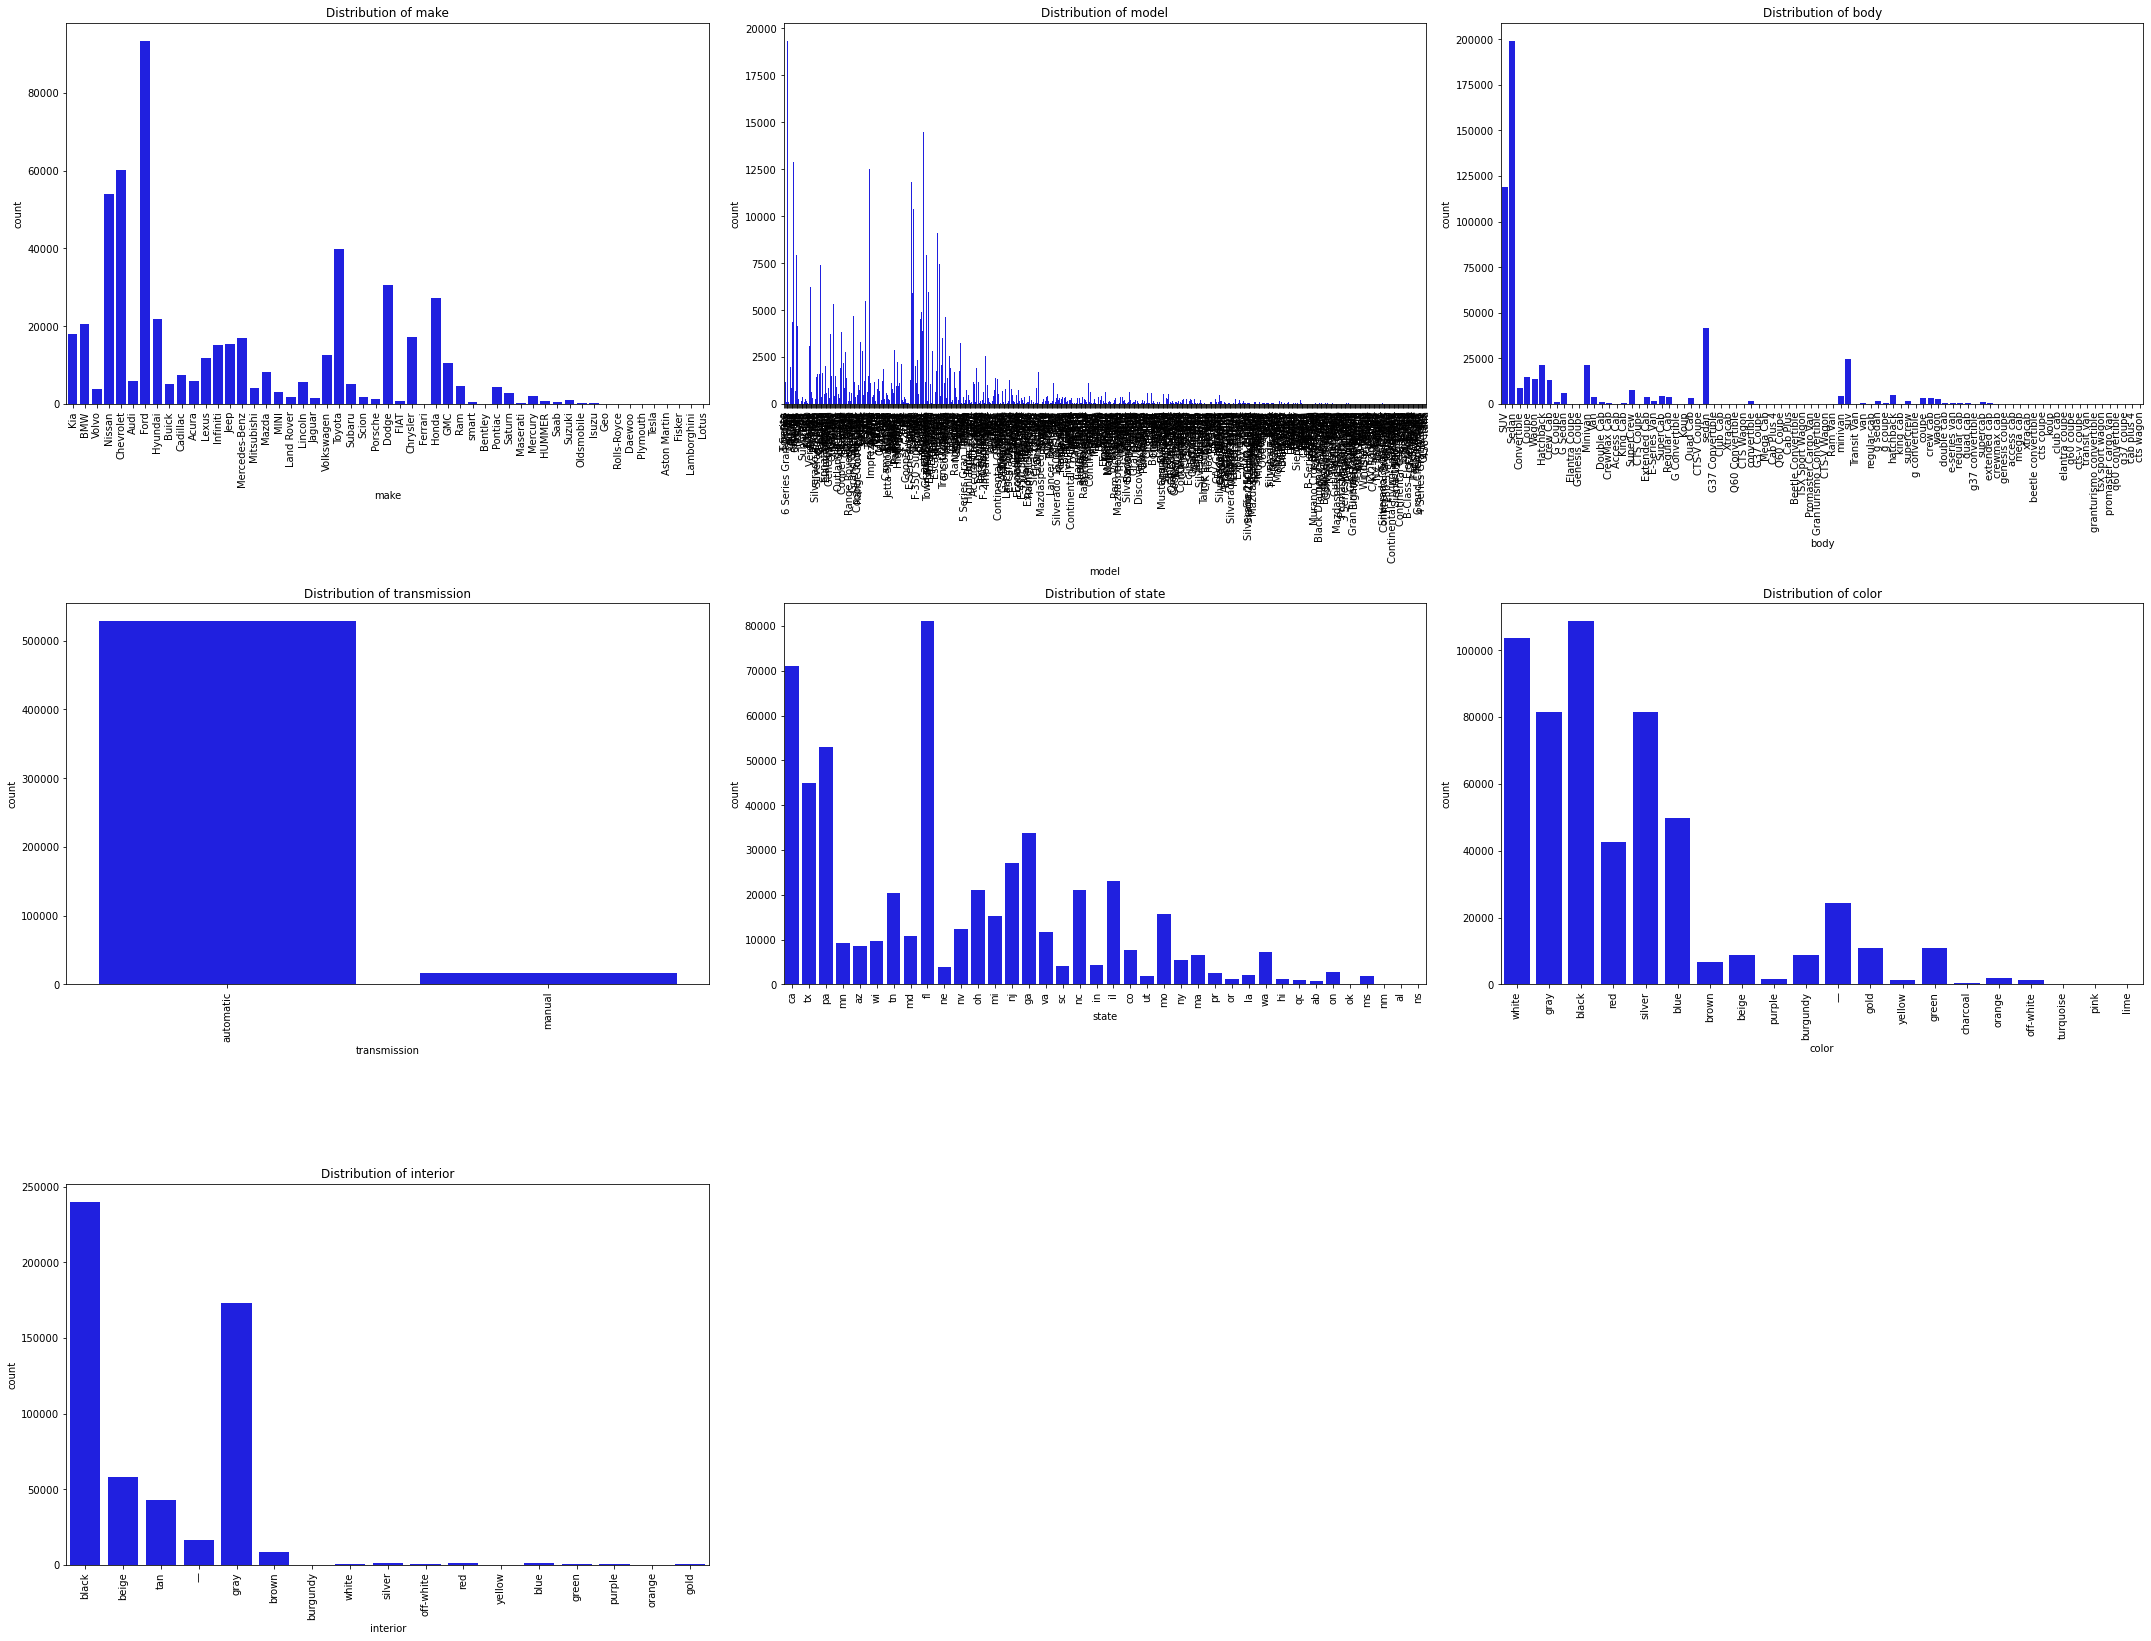

In [25]:
non_num = ['make', 'model', 'body', 'transmission', 'state', 'color', 'interior']
disp_categorical(df_log, non_num)

In [26]:
df_log.columns

Index(['year', 'make', 'model', 'trim', 'body', 'transmission', 'vin', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'mmr',
       'sellingprice', 'saledate', 'saledate_year', 'saledate_month',
       'saledate_week', 'saledate_day', 'saledate_hour', 'saledate_minute',
       'saledate_dayofweek'],
      dtype='object')

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 544795 entries, 0 to 558810
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   year                544795 non-null  int64              
 1   make                544795 non-null  object             
 2   model               544795 non-null  object             
 3   trim                544795 non-null  object             
 4   body                544795 non-null  object             
 5   transmission        544795 non-null  object             
 6   vin                 544795 non-null  object             
 7   state               544795 non-null  object             
 8   condition           544795 non-null  float64            
 9   odometer            544795 non-null  float64            
 10  color               544795 non-null  object             
 11  interior            544795 non-null  object             
 12  seller          

In [28]:
# df_log['odometer_binned'] = pd.qcut(df_log['odometer'], q=20)
# df_log['mmr_binned'] = pd.qcut(df_log['mmr'], q=20)
finalDf = df.drop(['vin','saledate'], axis=1)
finalDf["year"]=df["year"].astype(str)
finalDf["saledate_year"]=df["saledate_year"].astype(str)
finalDf["saledate_month"]=df["saledate_month"].astype(str)
finalDf["saledate_week"]=df["saledate_week"].astype(str)
finalDf["saledate_day"]=df["saledate_day"].astype(str)
finalDf["saledate_hour"]=df["saledate_hour"].astype(str)
finalDf["saledate_minute"]=df["saledate_minute"].astype(str)
finalDf["saledate_dayofweek"]=df["saledate_dayofweek"].astype(str)
finalDf.nunique()

year                      26
make                      53
model                    776
trim                    1528
body                      86
transmission               2
state                     38
condition              11150
odometer              169360
color                     20
interior                  17
seller                 14003
mmr                     1101
sellingprice            1871
saledate_year              2
saledate_month             8
saledate_week             32
saledate_day              31
saledate_hour             21
saledate_minute           40
saledate_dayofweek         7
dtype: int64

# CatBoost model

In [29]:
X = finalDf.drop("sellingprice", axis=1)
y = finalDf[["sellingprice"]]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [30]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]
print(categorical_features_indices)

[ 0  1  2  3  4  5  6  9 10 11 12 13 14 15 16 17 18 19]


In [31]:

model=CatBoostRegressor(iterations=100, depth=10, learning_rate=0.1, loss_function='RMSE')
model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_val, y_val),plot=True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 8832.2939660	test: 8825.5586667	best: 8825.5586667 (0)	total: 311ms	remaining: 30.8s
1:	learn: 8076.2819995	test: 8068.5452471	best: 8068.5452471 (1)	total: 487ms	remaining: 23.9s
2:	learn: 7400.9280070	test: 7408.1489515	best: 7408.1489515 (2)	total: 628ms	remaining: 20.3s
3:	learn: 6801.1769390	test: 6810.3729050	best: 6810.3729050 (3)	total: 761ms	remaining: 18.3s
4:	learn: 6267.4935938	test: 6285.2512570	best: 6285.2512570 (4)	total: 950ms	remaining: 18.1s
5:	learn: 5789.9784261	test: 5809.2639766	best: 5809.2639766 (5)	total: 1.14s	remaining: 17.9s
6:	learn: 5373.8640276	test: 5388.6591011	best: 5388.6591011 (6)	total: 1.3s	remaining: 17.2s
7:	learn: 5003.7121480	test: 5027.4648653	best: 5027.4648653 (7)	total: 1.44s	remaining: 16.5s
8:	learn: 4682.1599580	test: 4713.9485860	best: 4713.9485860 (8)	total: 1.57s	remaining: 15.9s
9:	learn: 4401.1768902	test: 4438.6907812	best: 4438.6907812 (9)	total: 1.71s	remaining: 15.4s
10:	learn: 4153.4501750	test: 4209.1755742	best: 42

86:	learn: 2216.3708973	test: 2261.1193086	best: 2261.1193086 (86)	total: 12.5s	remaining: 1.87s
87:	learn: 2214.4978277	test: 2259.8169316	best: 2259.8169316 (87)	total: 12.7s	remaining: 1.73s
88:	learn: 2211.4868706	test: 2256.6273692	best: 2256.6273692 (88)	total: 12.8s	remaining: 1.58s
89:	learn: 2208.5989573	test: 2254.0563725	best: 2254.0563725 (89)	total: 12.9s	remaining: 1.44s
90:	learn: 2204.9564736	test: 2251.0710538	best: 2251.0710538 (90)	total: 13.1s	remaining: 1.29s
91:	learn: 2202.1306934	test: 2249.1913159	best: 2249.1913159 (91)	total: 13.2s	remaining: 1.15s
92:	learn: 2199.4495170	test: 2246.7362291	best: 2246.7362291 (92)	total: 13.3s	remaining: 1s
93:	learn: 2194.7356401	test: 2244.1362112	best: 2244.1362112 (93)	total: 13.5s	remaining: 861ms
94:	learn: 2190.6683714	test: 2243.2027200	best: 2243.2027200 (94)	total: 13.6s	remaining: 717ms
95:	learn: 2188.9778087	test: 2241.9705539	best: 2241.9705539 (95)	total: 13.8s	remaining: 573ms
96:	learn: 2185.1799095	test: 223

In [32]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

# Feature Importance
As we can see the model is heavily reliant on the mmr of the car. This is kind of cheating so we will also create a model that does not use the mmr

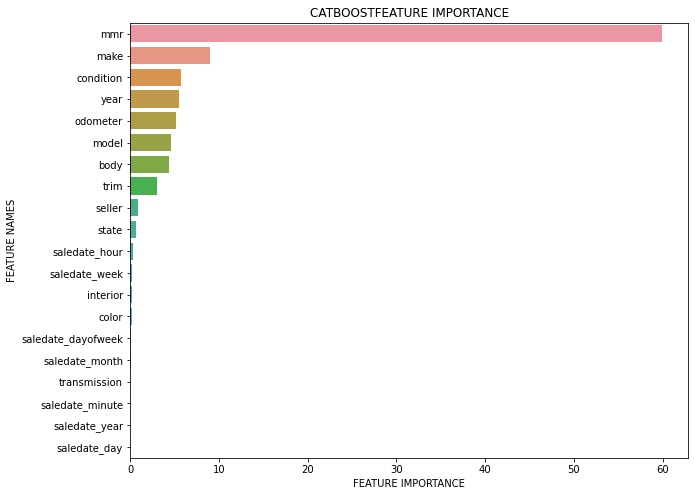

In [33]:
plot_feature_importance(model.get_feature_importance(),X_train.columns,'CATBOOST')

In [34]:
X_train2 = X_train.drop('mmr', axis=1)
categorical_features_indices2 = np.where(X_train2.dtypes != np.float)[0]
X_val2 = X_val.drop('mmr', axis=1)
print(categorical_features_indices)
model2=CatBoostRegressor(iterations=100, depth=10, learning_rate=0.1, loss_function='RMSE')
model2.fit(X_train2, y_train,cat_features=categorical_features_indices2,eval_set=(X_val2, y_val),plot=True);

[ 0  1  2  3  4  5  6  9 10 11 12 13 14 15 16 17 18 19]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 9025.6201012	test: 9017.0833277	best: 9017.0833277 (0)	total: 188ms	remaining: 18.7s
1:	learn: 8450.9293950	test: 8439.3589456	best: 8439.3589456 (1)	total: 344ms	remaining: 16.8s
2:	learn: 7945.9430801	test: 7939.2414834	best: 7939.2414834 (2)	total: 485ms	remaining: 15.7s
3:	learn: 7506.6373813	test: 7504.8208676	best: 7504.8208676 (3)	total: 619ms	remaining: 14.9s
4:	learn: 7119.4479481	test: 7116.8446748	best: 7116.8446748 (4)	total: 766ms	remaining: 14.5s
5:	learn: 6782.8005110	test: 6783.7748982	best: 6783.7748982 (5)	total: 927ms	remaining: 14.5s
6:	learn: 6484.0937977	test: 6487.9795566	best: 6487.9795566 (6)	total: 1.08s	remaining: 14.3s
7:	learn: 6207.9245400	test: 6209.9097071	best: 6209.9097071 (7)	total: 1.22s	remaining: 14.1s
8:	learn: 5960.0251010	test: 5968.2835783	best: 5968.2835783 (8)	total: 1.4s	remaining: 14.1s
9:	learn: 5745.2580709	test: 5753.4296817	best: 5753.4296817 (9)	total: 1.54s	remaining: 13.9s
10:	learn: 5546.3281674	test: 5552.0681117	best: 55

86:	learn: 3162.8780012	test: 3167.2061179	best: 3167.2061179 (86)	total: 12.5s	remaining: 1.86s
87:	learn: 3159.3927278	test: 3164.7941005	best: 3164.7941005 (87)	total: 12.6s	remaining: 1.72s
88:	learn: 3152.5606184	test: 3157.3210718	best: 3157.3210718 (88)	total: 12.8s	remaining: 1.58s
89:	learn: 3138.7511402	test: 3142.2942243	best: 3142.2942243 (89)	total: 12.9s	remaining: 1.43s
90:	learn: 3132.4290291	test: 3136.9502846	best: 3136.9502846 (90)	total: 13.1s	remaining: 1.29s
91:	learn: 3127.8305221	test: 3134.2325674	best: 3134.2325674 (91)	total: 13.2s	remaining: 1.15s
92:	learn: 3119.5402985	test: 3126.6879259	best: 3126.6879259 (92)	total: 13.3s	remaining: 1s
93:	learn: 3113.6639869	test: 3120.2714076	best: 3120.2714076 (93)	total: 13.5s	remaining: 859ms
94:	learn: 3101.5017154	test: 3106.1610075	best: 3106.1610075 (94)	total: 13.6s	remaining: 715ms
95:	learn: 3095.4036470	test: 3102.2418318	best: 3102.2418318 (95)	total: 13.7s	remaining: 572ms
96:	learn: 3079.7770794	test: 308

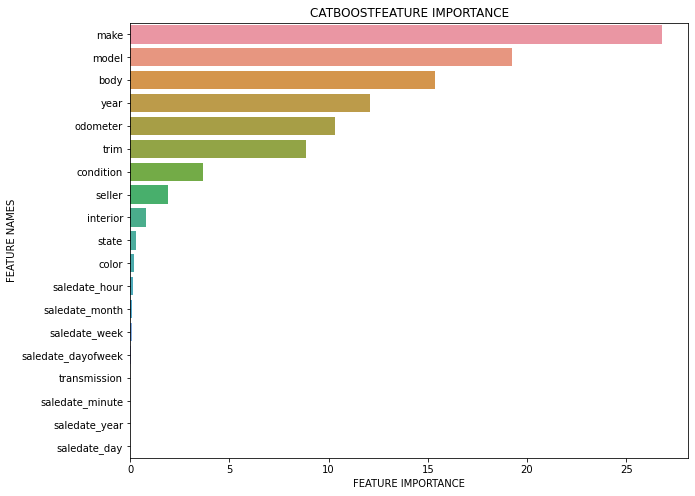

In [35]:
plot_feature_importance(model2.get_feature_importance(),X_train.drop('mmr', axis=1).columns,'CATBOOST')

In [38]:
X_train.drop('mmr', axis=1).columns

Index(['year', 'make', 'model', 'trim', 'body', 'transmission', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'saledate_year',
       'saledate_month', 'saledate_week', 'saledate_day', 'saledate_hour',
       'saledate_minute', 'saledate_dayofweek'],
      dtype='object')

In [41]:
prediction = model2.predict(['2009', 'BMW', '3 Series', '335i', 'Coupe', 'automatic',
       'nc', '', 96760, 'brown', 'tan', '', '',
       '', '', '', '', '', ''])

print(prediction)

8619.646664797683


![alt text](test.png "Title")

Considering that there is inflation and that prices can be bargained down the predicton of our algorithm seems to be successful!